In [1]:
import tensorflow as tf
from keras.optimizer_v1 import SGD
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from glob import glob
import matplotlib.pyplot as plt

In [2]:
# OCT images of 1024 x 1024 pixels with 1 channel
IMG_ROWS=224; IMG_COLS=224; IMG_CHANNELS=1
IMAGE_SIZE = [IMG_ROWS, IMG_COLS]


In [3]:
WHICH_MODEL = 'DenseNet121'

if WHICH_MODEL == 'VGG16':
    from keras.applications.vgg16 import VGG16
    from keras.applications.vgg16 import preprocess_input

    # for RGB channel use [3], for black and white use one channel [1], and IMAGE_SIZE + [3] = [224, 224, 3]
    orig_model = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)
    LEARN_RATE = 0.0001
    OCT_MODEL_NAME = 'VGG16_oct_minipigs.h5'

elif WHICH_MODEL == 'VGG19':
    from keras.applications.vgg19 import VGG19
    from keras.applications.vgg19 import preprocess_input

    # for RGB channel use [3], for black and white use one channel [1]
    orig_model = VGG19(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)
    LEARN_RATE = 0.0001
    OCT_MODEL_NAME = 'VGG19_oct_minipigs.h5'

elif WHICH_MODEL == 'ResNet50':
    from keras.applications.resnet50 import ResNet50
    from keras.applications.resnet50 import preprocess_input

    orig_model = ResNet50(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)
    LEARN_RATE = 0.001
    OCT_MODEL_NAME = 'ResNet50_oct_minipigs.h5'

elif WHICH_MODEL == 'InceptionV3':
    from keras.applications.inception_v3 import InceptionV3
    from keras.applications.inception_v3 import preprocess_input

    orig_model = InceptionV3(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)
    LEARN_RATE = 0.0001
    OCT_MODEL_NAME = 'InceptionV3_oct_minipigs.h5'

elif WHICH_MODEL == 'DenseNet121':
    from keras.applications.densenet import DenseNet121
    from keras.applications.densenet import preprocess_input

In [4]:
orig_model = DenseNet121(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)
LEARN_RATE = 0.0001
OCT_MODEL_NAME = 'DenseNet121_oct_minipigs.h5'


In [5]:
BATCH_SIZE = 32

EPOCHS = 100

In [6]:
# path to TRAINING dataset of the OCT images
TRAIN_PATH = 'C:\\Users\\Ali\Documents\\minipigs_cropped_images\\Split_Data\\train'

# path to VALIDATE dataset of the OCT images
VALID_PATH = 'C:\\Users\\Ali\\Documents\\minipigs_cropped_images\\Split_Data\\val'

# path to TESTING dataset of the OCT images
TEST_PATH = 'C:\\Users\\Ali\\Documents\\minipigs_cropped_images\\Split_Data\\test'

DATASET = 'Minipigs'

CLASS_MODE = 'categorical'   # binary, categorical

NUMBER_OF_CLASSES = 5


In [7]:

adam = Adam(learning_rate=LEARN_RATE)
#adam = Adam(learning_rate=LEARN_RATE, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False, name='Adam', decay=LEARN_RATE/EPOCHS)

#sgd = SGD(learning_rate=LEARN_RATE)

OPTIMISATION = adam  # SGD

# no need to train the weights again
for layer in orig_model.layers[:-8]:
    layer.trainable = False

In [8]:
# to retrieve the number of classes
folders = glob(TRAIN_PATH + '/*')

In [9]:
# more layers could be added to the model
x = Flatten()(orig_model.output)
x = Dropout(0.2)(x)

prediction = Dense(len(folders), activation='softmax')(x)

# create a model object
model = Model(inputs=orig_model.input, outputs=prediction)

In [10]:
# view the structure of the model
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
______________________________________________________________________________________________

In [11]:
# tell the model what cost and optimisation method to use
model.compile(
    loss='categorical_crossentropy',
    optimizer=OPTIMISATION,
    metrics=['accuracy']
)

In [12]:
train_datagen = ImageDataGenerator(
    rescale=1./255, rotation_range=350, width_shift_range=0.1,
    height_shift_range=0.1, shear_range=0.15, zoom_range=0.1,
    channel_shift_range=10., horizontal_flip=True, fill_mode='constant'
)

In [13]:
training_set = train_datagen.flow_from_directory(
    TRAIN_PATH,
    target_size=(IMG_ROWS, IMG_COLS),
    batch_size=BATCH_SIZE,
#    seed=42,
#    color_mode=COLOUR_MODE,
    class_mode=CLASS_MODE
)

Found 229 images belonging to 5 classes.


In [14]:
valid_datagen = ImageDataGenerator(
    rescale=1./255, rotation_range=350, width_shift_range=0.1,
    height_shift_range=0.1, shear_range=0.15, zoom_range=0.1,
    channel_shift_range=10., horizontal_flip=True, fill_mode='constant'
)

In [15]:
valid_set = valid_datagen.flow_from_directory(
    VALID_PATH,
    target_size=(IMG_ROWS, IMG_COLS),
    batch_size=BATCH_SIZE,
#    seed=42,
#    color_mode=COLOUR_MODE,
    class_mode=CLASS_MODE
)

Found 60 images belonging to 5 classes.


In [16]:
test_datagen = ImageDataGenerator(
    rescale=1./255
)

test_set = test_datagen.flow_from_directory(
    TEST_PATH,
    target_size=(IMG_ROWS, IMG_COLS),
    batch_size=BATCH_SIZE,
#    seed=42,
#    color_mode=COLOUR_MODE,
    class_mode=CLASS_MODE
)

Found 35 images belonging to 5 classes.


In [17]:
# fit the model
history = model.fit(
    training_set,
    validation_data=valid_set,
    epochs=EPOCHS,
    steps_per_epoch=len(training_set),
#    validation_split=0.1
    validation_steps=len(valid_set),

)

Epoch 1/100
8/8 [==============================] - 38s 4s/step - loss: 2.6292 - accuracy: 0.2183 - val_loss: 1.9176 - val_accuracy: 0.3000
Epoch 2/100
8/8 [==============================] - 33s 4s/step - loss: 2.3743 - accuracy: 0.2576 - val_loss: 1.6877 - val_accuracy: 0.3000
Epoch 3/100
8/8 [==============================] - 31s 4s/step - loss: 2.0431 - accuracy: 0.3843 - val_loss: 1.7134 - val_accuracy: 0.3833
Epoch 4/100
8/8 [==============================] - 30s 4s/step - loss: 1.8676 - accuracy: 0.4498 - val_loss: 1.7454 - val_accuracy: 0.3333
Epoch 5/100
8/8 [==============================] - 29s 4s/step - loss: 1.8422 - accuracy: 0.4323 - val_loss: 1.4443 - val_accuracy: 0.5167
Epoch 6/100
8/8 [==============================] - 30s 4s/step - loss: 1.6924 - accuracy: 0.4410 - val_loss: 1.6641 - val_accuracy: 0.4167
Epoch 7/100
8/8 [==============================] - 34s 4s/step - loss: 1.5244 - accuracy: 0.4803 - val_loss: 1.5118 - val_accuracy: 0.4167
Epoch 8/100
8/8 [==========

8/8 [==============================] - 32s 4s/step - loss: 0.8098 - accuracy: 0.7424 - val_loss: 0.9533 - val_accuracy: 0.6667
Epoch 60/100
8/8 [==============================] - 44s 6s/step - loss: 0.7290 - accuracy: 0.7555 - val_loss: 0.9715 - val_accuracy: 0.5833
Epoch 61/100
8/8 [==============================] - 45s 6s/step - loss: 0.8323 - accuracy: 0.7118 - val_loss: 1.1482 - val_accuracy: 0.6167
Epoch 62/100
8/8 [==============================] - 46s 6s/step - loss: 0.9212 - accuracy: 0.6725 - val_loss: 0.9568 - val_accuracy: 0.6500
Epoch 63/100
8/8 [==============================] - 38s 5s/step - loss: 0.7166 - accuracy: 0.7467 - val_loss: 0.9872 - val_accuracy: 0.7000
Epoch 64/100
8/8 [==============================] - 41s 5s/step - loss: 0.7725 - accuracy: 0.7162 - val_loss: 0.9128 - val_accuracy: 0.7167
Epoch 65/100
8/8 [==============================] - 41s 5s/step - loss: 0.7414 - accuracy: 0.7249 - val_loss: 0.9509 - val_accuracy: 0.6000
Epoch 66/100
8/8 [===============

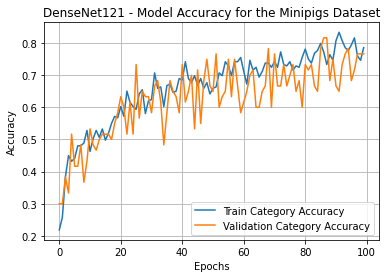

In [18]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
acc_title = "{} - Model Accuracy for the {} Dataset".format(WHICH_MODEL, DATASET)
plt.title(acc_title)
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.grid(True)
plt.legend(['Train Category Accuracy', 'Validation Category Accuracy'], loc='lower right')
plt.show()

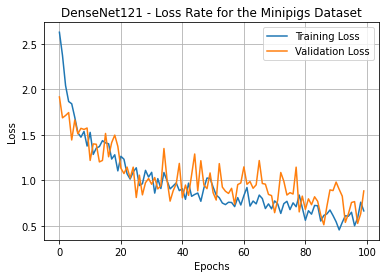

In [19]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
loss_title = "{} - Loss Rate for the {} Dataset".format(WHICH_MODEL, DATASET)
plt.title(loss_title)
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.grid(True)
plt.legend(['Training Loss', 'Validation Loss'], loc='upper right')
plt.show()

In [20]:
train_loss, train_acc = model.evaluate(training_set, steps=16)
valid_loss, valid_acc = model.evaluate(valid_set, steps=16)

print('\nLearn Rate =', LEARN_RATE, ', Epochs =', EPOCHS, ', Training Folder =', TRAIN_PATH)

print('Validation Folder =', VALID_PATH, ', Test Folder =', TEST_PATH)

print('\nTraining: %.3f, Validation: %.3f' % (train_acc, valid_acc))

print('\nThe processing of Convolutional Neural Networks with Transfer Learning for', WHICH_MODEL, 'succeed.\n')

16/16 [==============================] - 10s 327ms/step - loss: 0.8279 - accuracy: 0.7333

Learn Rate = 0.0001 , Epochs = 100 , Training Folder = C:\Users\Ali\Documents\minipigs_cropped_images\Split_Data\train
Validation Folder = C:\Users\Ali\Documents\minipigs_cropped_images\Split_Data\val , Test Folder = C:\Users\Ali\Documents\minipigs_cropped_images\Split_Data\test

Training: 0.825, Validation: 0.733

The processing of Convolutional Neural Networks with Transfer Learning for DenseNet121 succeed.



In [21]:
results = model.evaluate(test_set, steps=16)
print("\nTest loss and accuracy are:", results)

16/16 [==============================] - 5s 38ms/step - loss: 1.1018 - accuracy: 0.6857

Test loss and accuracy are: [1.10176682472229, 0.6857143044471741]



Predictions:

[[1.59504965e-01 4.89354879e-02 1.02470367e-04 7.90724933e-01
  7.32110755e-04]
 [9.99871135e-01 1.60426080e-05 1.37386522e-07 1.11998823e-04
  7.45042712e-07]
 [9.80928719e-01 6.12770952e-03 5.77637911e-05 1.40863340e-04
  1.27449315e-02]
 [2.78463185e-01 2.03919873e-01 2.11829523e-04 5.02545595e-01
  1.48594705e-02]
 [4.40785283e-04 9.99530792e-01 3.44211770e-09 2.65154558e-05
  1.85045485e-06]
 [9.99344409e-01 5.90911543e-04 3.24348761e-08 6.44776810e-05
  2.04723150e-07]
 [1.31190449e-01 9.12456438e-02 3.37156453e-05 7.77207494e-01
  3.22708860e-04]
 [7.65823002e-04 1.32332265e-03 2.75610569e-06 9.92169797e-01
  5.73839201e-03]
 [4.69212234e-01 8.44419673e-02 7.88754597e-03 5.89569936e-05
  4.38399345e-01]
 [9.19709873e-06 8.61049771e-01 2.51362170e-03 2.48527678e-04
  1.36178851e-01]
 [9.13718164e-01 8.62024203e-02 3.27642147e-06 4.53047251e-05
  3.08284725e-05]
 [9.71129715e-01 2.61360686e-02 8.09898847e-06 1.92112464e-03
  8.04900134e-04]
 [4.21110153e-01 5.786393

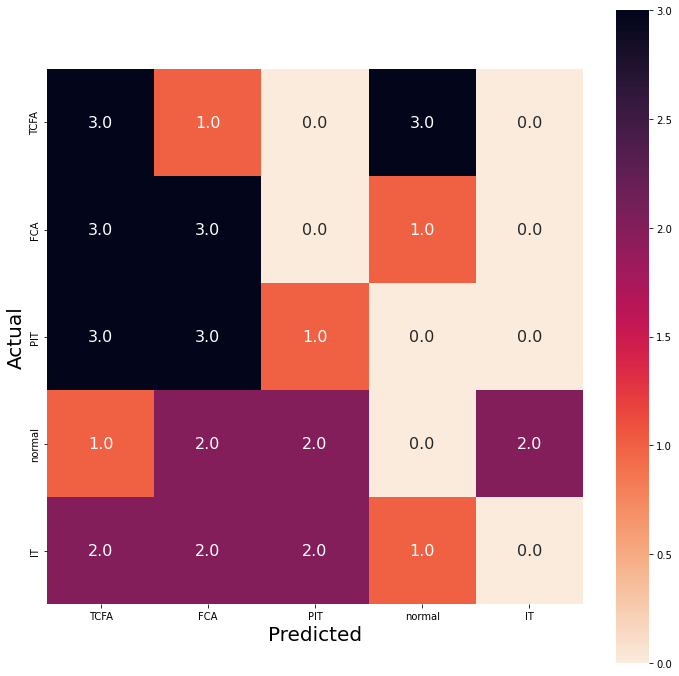

In [23]:
cnn_predictions = model.predict(test_set)
print('\nPredictions:\n')
print(cnn_predictions)

cnn_predictions_max = cnn_predictions.argmax(axis=1)
print('\nPredictions argmax(axis=1):\n')
print(cnn_predictions_max)

print(test_set.labels)

print('\nTesting execution ended.\n')

import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import multilabel_confusion_matrix

label = ['TCFA', 'FCA', 'PIT', 'normal', 'IT']
#Ypred = np.argmax(cnn_predictions, axis=1)
#Ytrue = np.argmax(test_set.labels, axis=0)

cm = confusion_matrix(test_set.labels, cnn_predictions_max)
plt.figure(figsize=(12, 12))
ax = sns.heatmap(cm, cmap="rocket_r", fmt=".01f",annot_kws={'size':16}, annot=True, square=True, xticklabels=label, yticklabels=label)
ax.set_ylabel('Actual', fontsize=20)
ax.set_xlabel('Predicted', fontsize=20)
plt.show()

In [24]:
model.save('model_0.2dropout_100epochs_v2.h5')